In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import combinations

from skbio.diversity import alpha_diversity, beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim, mantel
from skbio import DistanceMatrix
from skbio.tree import TreeNode
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


In [2]:
## helper functions

def trim_player_names(df):
    for col in df.columns:
        new = col.split(".")[0]
        df = df.rename(columns={col:new})
    return df
    

def alpha_plots(data_df, groupby, metric, ax):
    '''
    Create alpha diversity box plot with metric [metric] on matplotlib axis [ax]
    of pandas dataframe [data_df]. [data_df] contains counts and a single column [groupby]
    to denote grouping for box plot. 
    Returns pandas dataframe of alpha diversity for each sample.
    '''
    df_int = data_df.drop(columns=groupby,).astype(int)
    alpha_df = alpha_diversity(metric, df_int, df_int.index).to_frame(metric)
    alpha_df[groupby] = data_df[groupby]
    alpha_df.boxplot(metric, groupby, ax=ax, rot=75)
    return alpha_df
    
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    Create ellipse for scatter plot points in [x],[y] on matplotlib axis [ax] with standard deviation [n_std]
    and of color [facecolor]. Returns matplotlib.pathes.Ellipse.
    '''
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def beta_plot_ellipses(beta_dm, metadata, groupby, colormap, ax1PC, ax2PC):
    '''
    Create beta diversity scatter plot with 95% confidence elipses of distance matrix [beta_dm] grouped by column
    [groupby] in pandas dataframe [metadata] with colors [colormap] and axes [ac1PC], [ax2PC].
    '''
    fig, ax_kwargs = plt.subplots(figsize=(6, 6))
    uf_df = pcoa(beta_dm).samples
    uf_df = uf_df.join(metadata[metadata.index.isin(uf_df.index)])
    plt.xlabel(ax1PC)
    plt.ylabel(ax2PC)
    plt.title(f"Weighted Unifrac Beta Diversity - {sample_type}")

    for group in colormap.keys():
        group_pcoa_values = uf_df[uf_df[groupby]==group]
        x=group_pcoa_values[ax1PC]
        y=group_pcoa_values[ax2PC]
        confidence_ellipse(x, y, ax_kwargs, edgecolor=colormap[group])
        ax_kwargs.scatter(x, y, color=colormap[group])
    plt.show()

def unifrac_beta_plots(data_df, groupby, colormap, ax1PC, ax2PC):
    '''
    Create weighted unifrac beta diversity scatter plot of pandas dataframe [df_data]. 
    [data_df] contains counts and a single column [groupby] to denote grouping for plot.
    [colormap] is a dictionary where each key matches the values in [groupby] and values 
    respresent colors on the plot. Axes displayed are denoted by [ax1PC] and [ax2PC].
    Returns skbio.stats.distance.DistanceMatrix.
    '''
    otu_ids = data_df.drop(columns=groupby).columns.astype(str)
    counts = data_df.drop(columns=groupby).values
    uf_dm = beta_diversity("weighted_unifrac", counts=counts, ids=data_df.index, 
                            tree=tree, otu_ids=otu_ids)
    uf_df = pcoa(uf_dm).samples
    uf_df = uf_df.join(data_df[groupby])

    fg = sns.FacetGrid(data=uf_df, hue=groupby, height=6, palette=colormap,
                      hue_order=colormap.keys())
    fg.map(plt.scatter, ax1PC, ax2PC).add_legend()
    fg.fig.suptitle(f"Weighted Unifrac Beta Diversity - {sample_type}")
    plt.show()
    
    beta_plot_ellipses(uf_dm, data_df, groupby, colormap, ax1PC, ax2PC)
    
    anosim_values = anosim(uf_dm, uf_df, column=groupby, permutations=9999)
    print(f"all: p:{anosim_values['p-value']} r:{anosim_values['test statistic']}")
    return uf_dm

def compute_pvalues(dm, metadata, groupby):
    '''
    Prints p-value and r statistic for each pairing of groups in [metadata] column [groupby]
    with distance matrix [dm].
    '''
    beta_df = dm.to_data_frame().join(metadata[groupby])
    groups = beta_df[groupby].unique()
    for combo in combinations(groups, 2): 
        beta_df_oi = beta_df[beta_df[groupby].isin(combo)]
        beta_df_oi = beta_df_oi[beta_df_oi.index]
        dm_combo = DistanceMatrix(beta_df_oi.values, beta_df_oi.index)
        anosim_values = anosim(dm_combo, metadata[metadata.index.isin(beta_df_oi.index)], column=groupby, permutations=9999)
        print(f"{combo}: p:{anosim_values['p-value']} r:{anosim_values['test statistic']}")
        
    

In [3]:
sample_types = ["fecal", "saliva"]
ranks = ["species", "genus", "family", "phylum"]
sample_type = sample_types[0]    
rank = ranks[0]        
metadata_df = pd.read_csv(f"football19_data/metadata/{sample_type}_metadata.csv", index_col=0)
counts_df = pd.read_csv(f"football19_data/abundance_spreadsheets/counts/{sample_type}_{rank}_counts.tsv", index_col=None,sep="\t")

# keep only taxa where a sample contains at least 3 reads
counts_df = trim_player_names(counts_df)
counts_df = counts_df[counts_df["Max"]>2]
counts_df_names = counts_df.drop(columns=["taxRank","taxID","Max","lineage"]).fillna(0).set_index("name")
counts_df = counts_df.drop(columns=["taxRank","name","Max","lineage"]).fillna(0).set_index("taxID")
counts_df = counts_df.transpose()

# Save spreadsheets with reduced noise
counts_df_names.to_csv(f"football19_data/abundance_spreadsheets/counts_dropped/{sample_type}_{rank}_counts_dropped.tsv", sep='\t')
taxa = counts_df_names.index
df_percent = pd.read_csv(f"football19_data/abundance_spreadsheets/percent/{sample_type}_{rank}_percent.tsv", index_col="name",sep="\t")
df_percent = trim_player_names(df_percent)
df_percent.loc[taxa].to_csv(f"football19_data/abundance_spreadsheets/percent_dropped/{sample_type}_{rank}_percent_dropped.tsv", sep='\t')

# extract longitudinal analysis data
long_df = counts_df.copy()
long_df['concussion'] = metadata_df['post-concussion']
long_df['timepoint'] = metadata_df['timepoint']
long_df = long_df[long_df.concussion == "no"]
long_df = long_df.drop(columns='concussion')
long_groups = ["Mid-season", "Post-season", "Off-season"]
long_colors = ["#0076F5", "#FECB34", "#707070"]
long_colormap = dict(zip(long_groups, long_colors))

# extract concussion analysis data
conc_df = counts_df.copy()
conc_df['group'] = metadata_df['group']
conc_groups = ["In-season", "In-season Concussion", "Off-season", "Off-season Concussion"]
conc_colors = ["#62BC78", "#DA4944", "#707070", "#EB9B98"]
conc_colormap = dict(zip(conc_groups, conc_colors))

# extract concussion longitudinal analysis data
conc_long_df = counts_df.copy()
conc_long_df['group'] = metadata_df['all_timepoints_conc']
conc_long_df = conc_long_df[conc_long_df['group'] != "-"]
conc_long_groups = ["Pre-concussion", "Post-concussion", "Off-season"]
conc_long_colors = ["#0076F5", "#DA4944", "#EB9B98"]
conc_long_colormap = dict(zip(conc_long_groups, conc_long_colors))

# create taxonomy tree
tree = TreeNode.read(f"tax_trees/kraken_bacarch_tree_{rank}.nwk", format='newick')
# add unclassified lachnospiraceace and ruminococcaceae to tree
if rank == "genus":
    lachnospiraceae = tree.find('186803') 
    unclass_lachno = TreeNode(name='186928', length=1, parent=lachnospiraceae)
    lachnospiraceae.append(unclass_lachno)
    ruminococcaceae = tree.find('541000')
    unclass_rumino = TreeNode(name='552397', length=1, parent=ruminococcaceae)
    ruminococcaceae.append(unclass_rumino)



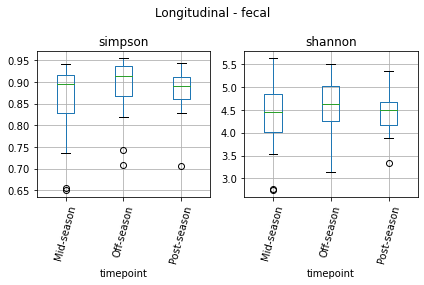

In [4]:
## alpha diversity - longitudinal

fig, axes = plt.subplots(nrows=1, ncols=2)

simpson_long = alpha_plots(long_df, groupby="timepoint", metric="simpson", ax=axes[0])
shannon_long = alpha_plots(long_df, groupby="timepoint", metric="shannon", ax=axes[1])

shannon_long.to_csv(f"football19_data/alpha_diversity/{rank}/{sample_type}_longitudinal_shannon.tsv", sep='\t')
simpson_long.to_csv(f"football19_data/alpha_diversity/{rank}/{sample_type}_longitudinal_simpson.tsv", sep='\t')


plt.suptitle(f"Longitudinal - {sample_type}")
fig.tight_layout()

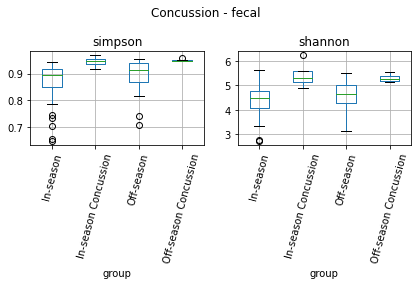

In [5]:
## alpha diversity - concussion

fig, axes = plt.subplots(nrows=1, ncols=2)

simpson_conc = alpha_plots(conc_df, groupby="group", metric="simpson", ax=axes[0])
shannon_conc = alpha_plots(conc_df, groupby="group", metric="shannon", ax=axes[1])

shannon_conc.to_csv(f"football19_data/alpha_diversity/{rank}/{sample_type}_conc_shannon.tsv", sep='\t')
simpson_conc.to_csv(f"football19_data/alpha_diversity/{rank}/{sample_type}_conc_simpson.tsv", sep='\t')


plt.suptitle(f"Concussion - {sample_type}")
fig.tight_layout()

/Users/kcurry/miniconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.3037207826539703 and the largest is 69.17950411367397.
  RuntimeWarning


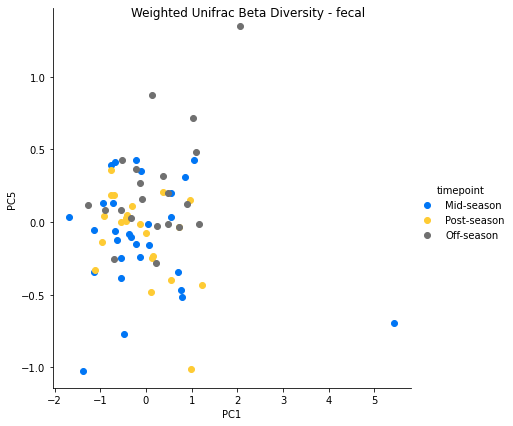

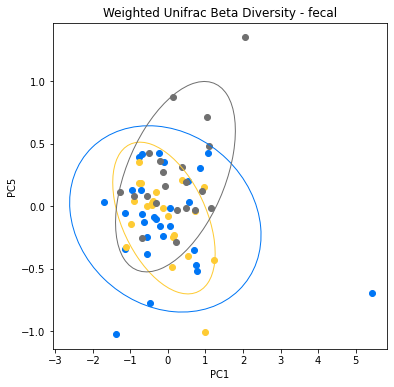

all: p:0.3545 r:0.006366047378867154
('Mid-season', 'Off-season'): p:0.1753 r:0.03192374128334728
('Mid-season', 'Post-season'): p:0.9666 r:-0.048065235257353574
('Off-season', 'Post-season'): p:0.0516 r:0.05262537915599142


In [6]:
## beta diversity -  longitudinal analysis 

long_beta_dm = unifrac_beta_plots(long_df, "timepoint", long_colormap, "PC1", "PC5")
long_pvalues = compute_pvalues(long_beta_dm, long_df, "timepoint")

In [7]:
## beta diversity -  concussion analysis 

conc_beta_dm = unifrac_beta_plots(conc_df, "group", conc_colormap, "PC1", "PC3")
conc_pvalues = compute_pvalues(conc_beta_dm, conc_df, "group")


/Users/kcurry/miniconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.9842379174789517 and the largest is 117.73714673517942.
  RuntimeWarning


all: p:0.0004 r:0.23093973073426866
('In-season Concussion', 'In-season'): p:0.0153 r:0.3959376100166843
('In-season Concussion', 'Off-season'): p:0.0672 r:0.28075396825396826
('In-season Concussion', 'Off-season Concussion'): p:0.4899 r:0.01041666666666671
('In-season', 'Off-season'): p:0.1072 r:0.07339187077749182
('In-season', 'Off-season Concussion'): p:0.0004 r:0.7058211262647135
('Off-season', 'Off-season Concussion'): p:0.0033 r:0.5710978835978835
